In [66]:
from cftime import DatetimeNoLeap
from datetime import timedelta
from os import chdir, system
from mpl_toolkits.basemap import interp
from numpy import datetime64, empty, full, repeat, stack
from scipy.interpolate import griddata
from xarray import DataArray, open_dataset

**Data**

In [2]:
nc_path = '/home/zhangc/scenariomip_cmip6/nc_data/'
im_path = '/home/zhangc/scenariomip_cmip6/im_data/'
os_path = '/home/zhangc/repositories/nc2im_cesm2/'

In [3]:
nc_con = ['fracdata_0.9x1.25_gx1v6_c090317.nc',
          'USGS-gtopo30_0.9x1.25_remap_c051027.nc']

In [4]:
nc_6hr = ['ta_6hrLev_CESM2_ssp245_r2i1p1f1_gn_201501010000-202412311800.nc',
          'hus_6hrLev_CESM2_ssp245_r2i1p1f1_gn_201501010000-202412311800.nc',
          'ua_6hrLev_CESM2_ssp245_r2i1p1f1_gn_201501010000-202412311800.nc',
          'va_6hrLev_CESM2_ssp245_r2i1p1f1_gn_201501010000-202412311800.nc',
          'ps_6hrLev_CESM2_ssp245_r2i1p1f1_gn_201501010000-202412311800.nc']

In [5]:
nc_day = ['tos_Oday_CESM2_ssp245_r2i1p1f1_gn_20150102-20650101.nc',
          'siconc_SIday_CESM2_ssp245_r2i1p1f1_gn_20150102-20650101.nc']

In [6]:
nc_mon = ['ts_Amon_CESM2_ssp245_r2i1p1f1_gn_201501-206412.nc']

In [7]:
nc_era = ['soil_mon_ERA5_2015.nc']

In [8]:
chdir(nc_path)

**Time**

In [52]:
tnum = 2015, 1, 1
t6hr = DatetimeNoLeap(tnum[0], tnum[1], tnum[2])
tday = t6hr + timedelta(days=1)
tmon = DatetimeNoLeap(tnum[0], tnum[1], 15, 12)
tera = datetime64('2015-'+str(tnum[1]).zfill(2)+'-01')
file_time = str(t6hr).replace(' ', '_')

**Constant**

In [10]:
ds = open_dataset(nc_con[0])
da = ds.LANDMASK*1.0
file_name = 'ls_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

In [11]:
ds = open_dataset(nc_con[1])
da = ds.PHIS/9.81
file_name = 'sh_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

**6 Hourly**

In [12]:
das = []

In [13]:
for nc in nc_6hr:
    ds = open_dataset(nc).sel(time=t6hr)
    vi = ds.variable_id
    da = ds[vi]
    das.append(da)
    file_name = vi + '_' + file_time + '.nc'
    da.to_netcdf(im_path+file_name)

/home/zhangc/miniconda3/envs/python3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'ta' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/home/zhangc/miniconda3/envs/python3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'hus' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/home/zhangc/miniconda3/envs/python3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'ua' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/home/zhangc/miniconda3/envs/python3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'va' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/home/zhangc/miniconda3/envs/python3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarnin

**3D Geopotential Heights** Virtual Temperature

In [14]:
t = das[0].sortby('lev').values
q = das[1].sortby('lev').values
tv = t*(1.+q*0.61)

In [15]:
lev = -das[0].sortby('lev').lev.values
lat = das[0].lat.values
lon = das[0].lon.values

In [16]:
da = DataArray(name='tv', data=tv, coords=[lev, lat, lon], dims=['lev', 'lat', 'lon']).transpose('lat', 'lon', 'lev')
file_name = 'tv_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

**3D Geopotential Heights** Pressure

In [17]:
shape = das[0].shape
p3 = empty(shape)
for i in range(len(lev)):
    p3[i] = full(shape[1:3], lev[i])

In [18]:
da = DataArray(name='p3', data=p3, coords=[lev, lat, lon], dims=['lev', 'lat', 'lon']).transpose('lat', 'lon', 'lev')
file_name = 'p3_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

**Surface Variables**

In [19]:
vis = ['t2', 'q2', 'u2', 'v2']

In [20]:
for i in range(4):
    da = das[i].isel(lev=-1)
    file_name = vis[i] + '_' + file_time + '.nc'
    da.to_netcdf(im_path+file_name)

In [21]:
for nc in nc_mon:
    ds = open_dataset(nc).sel(time=tmon)
    vi = ds.variable_id
    da = ds[vi]
    file_name = vi + '_' + file_time + '.nc'
    da.to_netcdf(im_path+file_name)

/home/zhangc/miniconda3/envs/python3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'ts' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [22]:
da = das[0].isel(lev=-1)
lev = da.lev.values*-100
lon = da.lon.values
lat = da.lat.values
values = full(da.shape, lev)
da = DataArray(name='p2', data=values, coords=[lat, lon], dims=['lat', 'lon'])
file_name = 'p2_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

**Sea Surface Temperature**

In [62]:
ds = open_dataset(nc_day[0])
da = ds.tos.sel(time=tday)
x = da.lon.values.flatten()
y = da.lat.values.flatten()
xy = stack((x, y), axis=-1)
v = da.values.flatten()

/home/zhangc/miniconda3/envs/python3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [24]:
ds = open_dataset(nc_6hr[0])
lon1d = ds.lon.values
lat1d = ds.lat.values
nx = len(lon1d)
ny = len(lat1d)
lon2d = repeat(lon1d, ny).reshape(nx, ny).transpose()
lat2d = repeat(lat1d, nx).reshape(ny, nx)

In [25]:
vi = griddata(xy, v, (lon2d, lat2d), method='linear')
da = DataArray(data=vi, coords=[lat1d, lon1d], dims=['lat', 'lon'])
file_name = 'sst_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

**Sea Ice Concentration**

In [26]:
ds = open_dataset(nc_day[1])
da = ds.siconc.sel(time=tday)
v = da.values.flatten()

/home/zhangc/miniconda3/envs/python3/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'siconc' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,


In [27]:
vi = griddata(xy, v, (lon2d, lat2d), method='linear')
da = DataArray(data=vi, coords=[lat1d, lon1d], dims=['lat', 'lon'])
file_name = 'sic_' + file_time + '.nc'
da.to_netcdf(im_path+file_name)

**Soil Moisture**

In [76]:
ds = open_dataset(nc_era[0]).sel(time=tera)

In [79]:
x1d = ds.longitude.values
y1d = ds.latitude.values
nx = len(x1d)
ny = len(y1d)

In [81]:
x2d = repeat(x1d, ny).reshape(nx, ny).transpose()
y2d = repeat(y1d, nx).reshape(ny, nx)

In [87]:
x2df = x2d.flatten()
y2df = y2d.flatten()
xy = stack((x2df, y2df), axis=-1)

In [99]:
da = ds[vis[0]]

In [104]:
di = da.interp(longitude=lon, latitude=lat)

In [97]:
da

<xarray.DataArray 'swvl2' (longitude: 3600)>
array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.1 0.2 0.3 ... 359.6 359.7 359.8 359.9
    latitude   float32 90.0
    time       datetime64[ns] 2015-01-01
Attributes:
    units:      m**3 m**-3
    long_name:  Volumetric soil water layer 2

In [102]:
lon

array([  0.  ,   1.25,   2.5 ,   3.75,   5.  ,   6.25,   7.5 ,   8.75,
        10.  ,  11.25,  12.5 ,  13.75,  15.  ,  16.25,  17.5 ,  18.75,
        20.  ,  21.25,  22.5 ,  23.75,  25.  ,  26.25,  27.5 ,  28.75,
        30.  ,  31.25,  32.5 ,  33.75,  35.  ,  36.25,  37.5 ,  38.75,
        40.  ,  41.25,  42.5 ,  43.75,  45.  ,  46.25,  47.5 ,  48.75,
        50.  ,  51.25,  52.5 ,  53.75,  55.  ,  56.25,  57.5 ,  58.75,
        60.  ,  61.25,  62.5 ,  63.75,  65.  ,  66.25,  67.5 ,  68.75,
        70.  ,  71.25,  72.5 ,  73.75,  75.  ,  76.25,  77.5 ,  78.75,
        80.  ,  81.25,  82.5 ,  83.75,  85.  ,  86.25,  87.5 ,  88.75,
        90.  ,  91.25,  92.5 ,  93.75,  95.  ,  96.25,  97.5 ,  98.75,
       100.  , 101.25, 102.5 , 103.75, 105.  , 106.25, 107.5 , 108.75,
       110.  , 111.25, 112.5 , 113.75, 115.  , 116.25, 117.5 , 118.75,
       120.  , 121.25, 122.5 , 123.75, 125.  , 126.25, 127.5 , 128.75,
       130.  , 131.25, 132.5 , 133.75, 135.  , 136.25, 137.5 , 138.75,
      

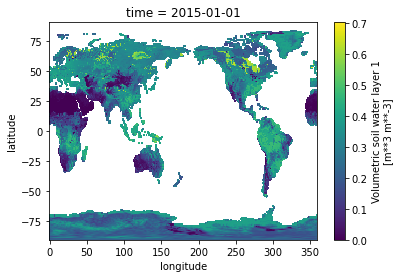

In [109]:
di.plot()

**Soil Temperature**

In [100]:
v = da.values.flatten()
vi = griddata(xy, v, (lon2d, lat2d), method='linear')

KeyboardInterrupt: 

In [88]:
vis = ['swvl1', 'swvl2', 'swvl3', 'swvl4']
for vi in vis:
    da = ds[vi]
    v = da.values.flatten()
    vi = griddata(xy, v, (lon2d, lat2d), method='linear')

KeyboardInterrupt: 

In [30]:
#chdir(os_path)

In [31]:
#command = 'ncl convert_nc_to_im.ncl ' + "'file_time=" + '"' + file_time + '"' + "'"

In [32]:
#system(command)